In [1]:
from data_tidy import read_a_season,read_seasons,read_all_game

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn
import os

In [15]:
if not os.path.exists("../csv/"):
    os.makedirs("../csv/")
read_a_season("../nhl_data/",2016).to_csv('../csv/tidy_{season}.csv'.format(season=2016), sep=',',index=False)

100%|█████████████████████████████████████████████████████████████████████████████| 6433/6433 [00:18<00:00, 356.46it/s]


In [16]:
for year in [2018,2019,2020]:
    read_a_season("../nhl_data/",year).to_csv('../csv/tidy_{season}.csv'.format(season=year), sep=',',index=False)

100%|█████████████████████████████████████████████████████████████████████████████| 6433/6433 [00:11<00:00, 581.78it/s]


In [3]:
season_2016_path = "../csv/tidy_2016.csv"
season_2018_path = "../csv/tidy_2018.csv"
season_2019_path = "../csv/tidy_2019.csv"
season_2020_path = "../csv/tidy_2020.csv"

In [4]:
def bars_type_goal(year:int,csv_path:str):
    """"
    Parameters:
    year(int): start year of a season
    csv_path(str): path of csv file for this season
    
    This function will return a bar plot of the relationship between
    different shot types, their total number of goals, total number of shots,
    and their chance of goals annoted on the top of each bar.
    """
    df = pd.read_csv(csv_path).reset_index()
    df_shots = df.groupby(["attack_team_name","shot_type"]).agg("count").reset_index()
    df_shots = df_shots.pivot(columns = "attack_team_name",index = "shot_type", values = "index")
    df_total = pd.DataFrame(df_shots.sum(axis=1),columns = ["total_shot"])
    # df_total
    df_goals = df[df["play_type"]=="Goal"]
    df_goals = df_goals.groupby(["attack_team_name","shot_type"]).agg("count").reset_index()
    df_goals = df_goals.pivot(columns = "attack_team_name",index = "shot_type", values = "index")
    df_goals_total = pd.DataFrame(df_goals.sum(axis=1),columns = ["total_goal"]).astype(int)
    # df_goals_total
    df_pt1 = pd.concat([df_goals_total,df_total],axis = 1)
    df_pt1["percentage"] = df_pt1["total_goal"]/df_pt1["total_shot"]*100
    df_pt1["percentage"] = df_pt1["percentage"].round(1)
    # df_pt1
    ax = df_pt1[["total_goal","total_shot"]].plot.bar(stacked=True,rot=70)
    # annotation part inspired by: 
    # https://stackoverflow.com/questions/23591254/python-pandas-matplotlib-annotating-labels-above-bar-chart-columns
    # This part is to annotate each bar with chance of goals
    for i,p in enumerate(ax.patches):
        #to show on top
        if i>=7:
            ax.annotate(str(list(df_pt1["percentage"])[i-7])+"%",
                        xy=(p.get_x()+p.get_width()/2, 1.1*p.get_height()),
                        ha='center')
    plt.title(f"Relationship between shot type and chance of goal of season {year}-{year+1}")
    plt.ylabel("Number of shots/goals")
    plt.show()

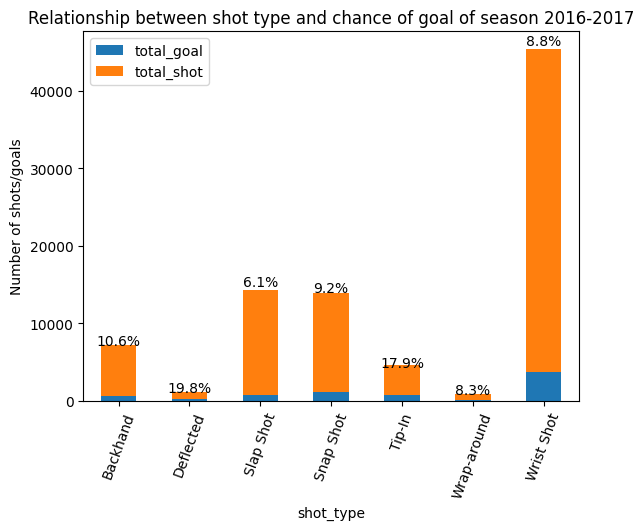

In [5]:
bars_type_goal(2016,season_2016_path)

 ####  What appears to be the most dangerous type of shot? 
- For season 2016-2017, **Deflected** is the most dangerous one, its chance of shot has gotton 19.8% which is the highest among all.
#### The most common type of shot? 
- *Wrist shot* is the most common type of shot.
#### Why did you choose this figure? 
- This figure shows *number of shots*, *goals* and *chance of goal* for each type of shot.

In [19]:
def dist_shot_plot(year:int,csv_path:str,bin_gap:int):
    """"
    Parameters:
    year(int): start year of a season
    csv_path(str): path of csv file for this season
    bin_gap: gap to split distance into different intervals
    
    This function will return a bar plot of the relationship between
    different range of distance and their chance of goals annoted on the top of each bar(%).
    """
    #bins for cutting dataframe into different pieces according to their shot distance
    max_dist = np.sqrt((100*2)**2+42.5**2)
    bins=list(range(0,round(max_dist),bin_gap))
    df = pd.read_csv(csv_path).reset_index()
    df_dist = df[["shot_dist","play_type"]]
    
    # Remove NaN rows
    idx = ~pd.isna(df_dist["shot_dist"])
    df_filtered = df_dist.loc[idx]
    df_filtered_shot = df_filtered
    df_filtered_goal = df_filtered[df_filtered["play_type"]=="Goal"]
    
    # cutting dataframes into pieces
    shot_count=pd.DataFrame(pd.cut(df_filtered_shot["shot_dist"],bins=bins)).reset_index()
    shot_count= shot_count.groupby("shot_dist", observed=True).agg("count")
    shot_count = shot_count.rename(columns={'index': 'Shots'})

    goal_count=pd.DataFrame(pd.cut(df_filtered_goal["shot_dist"],bins=bins)).reset_index()
    goal_count= goal_count.groupby("shot_dist", observed=True).agg("count")
    goal_count = goal_count.rename(columns={'index': 'Goals'})
    
    shot_goal = pd.concat([shot_count,goal_count],axis=1)
    shot_goal["Percentage"] = round(100* shot_goal["Goals"]/shot_goal["Shots"],1)
    shot_goal
    
    ax = shot_goal["Percentage"].plot.bar(rot=70)
    ax.bar_label(ax.containers[0])
    plt.title(f"Relationship between shot distance and chance of goal of season {year}-{year+1}")
    plt.ylabel("Chance of Gaols(%)")
    plt.show() 


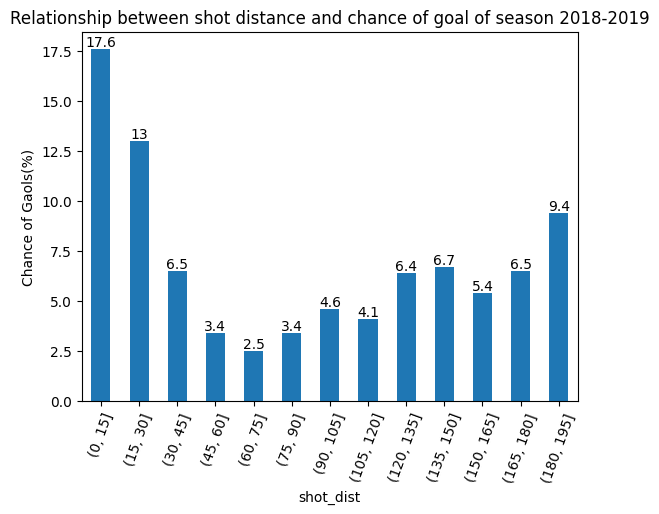

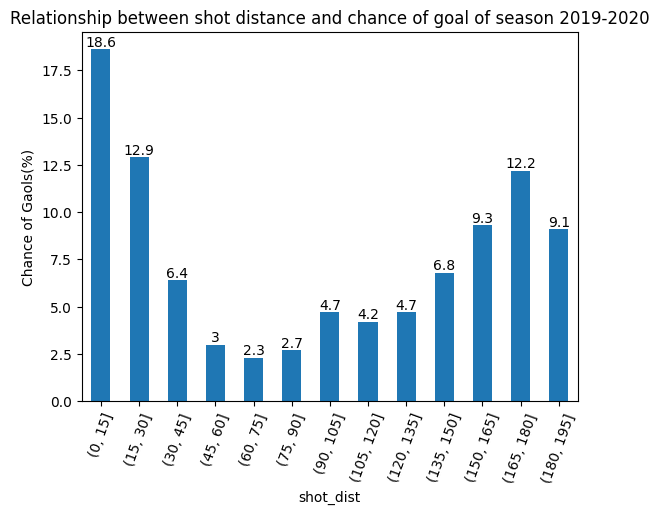

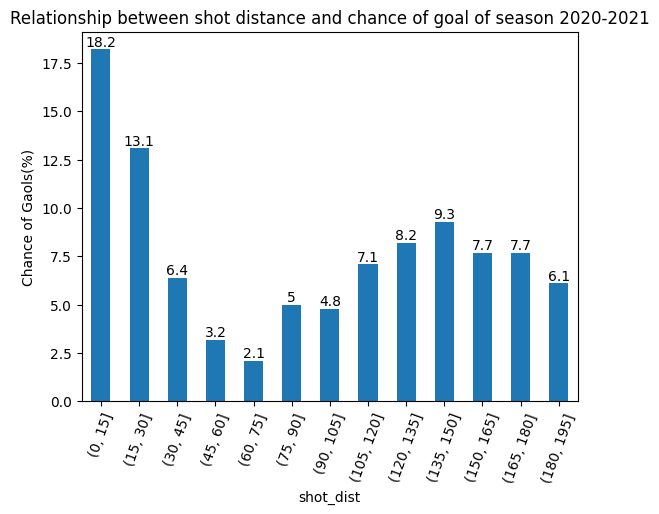

In [20]:
dist_shot_plot(2018,season_2018_path,15)
dist_shot_plot(2019,season_2019_path,15)
dist_shot_plot(2020,season_2020_path,15)

###  Has there been much change over the past three seasons? 
- One significant change could be the chance of goal at long distances has decreased, in long distance, the high chance area has moved from [180,195] to [135,150].
### Why did you choose this figure?
- Because the chance of goal in each area can well represent the relationship of chance of goal and distance if the gap of each interval is small.
- Bar plot can clearly show how different the chance of goals are for each interval of ditance.

In [33]:
def heat_type_dist(year:int,csv_path:str,bin_gap:int):
    """"
    Parameters:
    year(int): start year of a season
    csv_path(str): path of csv file for this season
    bin_gap: gap to split distance into different intervals
    
    This function will return a heatmap of the relationship between
    different range of distance, shot types and their chance of goals annoted on each grid(%).
    """
    df = pd.read_csv(csv_path).reset_index()
    
    max_dist = np.sqrt((100*2)**2+42.5**2)
    bins=list(range(0,round(max_dist),bin_gap))
    
    df_whole = df[["shot_dist","play_type","shot_type"]]
    idx = ~pd.isna(df["shot_dist"])
    df_whole = df_whole.loc[idx].sort_values('shot_dist')
    
    df_whole_shot = df_whole.groupby(["shot_dist","shot_type"]).agg("count").reset_index()
    df_whole_shot = df_whole_shot.pivot(index = "shot_dist",columns = "shot_type",values = "play_type").fillna(0).astype(int).reset_index()
    df_whole_shot["intervals_play_dist"]= pd.cut(df_whole_shot["shot_dist"],bins=bins)
    df_whole_shot = df_whole_shot.groupby("intervals_play_dist", observed=True).agg("sum")
    df_whole_shot = df_whole_shot[["Backhand","Deflected","Slap Shot","Snap Shot","Tip-In","Wrap-around","Wrist Shot"]]
    
    df_whole_goal = df_whole[df_whole["play_type"]=="Goal"].groupby(["shot_dist","shot_type"]).agg("count").reset_index()
    df_whole_goal = df_whole_goal.pivot(index = "shot_dist",columns = "shot_type",values = "play_type").fillna(0).astype(int).reset_index()
    df_whole_goal["intervals_play_dist"]= pd.cut(df_whole_goal["shot_dist"],bins=bins)
    df_whole_goal = df_whole_goal.groupby("intervals_play_dist", observed=True).agg("sum")
    df_whole_goal = df_whole_goal[["Backhand","Deflected","Slap Shot","Snap Shot","Tip-In","Wrap-around","Wrist Shot"]]
    
    df_type_dist = df_whole_goal/df_whole_shot
    df_type_dist.astype(float)
    ht = seaborn.heatmap(df_type_dist,cmap="viridis",annot=True)
    
    plt.title(f"Relationship between shot distance, shot type and chance of goal of season {year}-{year+1}")
    plt.show() 

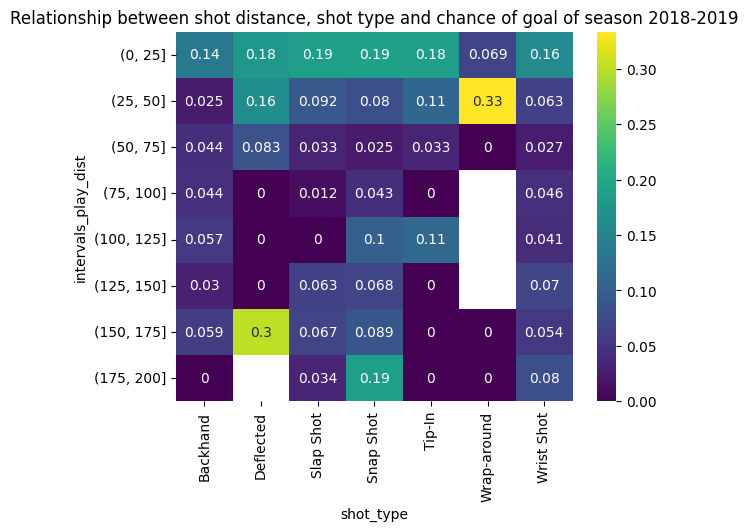

In [34]:
heat_type_dist(2018,season_2018_path,25)

### Briefly discuss your findings
- We have used a heatmap to show the goal percentage as a function of both distance from the net, and the category of shot types， the y axis represents different range of shot distance, x axis shows different type of shots, each grid shows the chance of goals as function of a distance and a shot type(ex. if a Wrist Shot happens in a distance between 75 and 100, the chance of goal is 4.6%). The brighter the color of a grid is, the more chance of goal it will be. White grid represents *NaN* value, which means there's no such cases for us to calculate the chance(ex.0 Wrap-around shot at 125 to 150).
#### what might be the most dangerous types of shots?
- Wrap-around at a distance between 25 and 50(which is a relavently close distance to net).